## 3. Signal processing / System identification

#### Signal processing (Consider two analyses in different frequency bands)
- ~~Filter and Decimation (IIR Filter)~~ (sample has been sampled already in the desired frequency band to keep uq less complex)
    - $M = $ ~~Number of IIR filter coefficients ("order")~~
    - $f_c =$ ~~Filter 3 dB cutoff frequency~~
    - $d = $ ~~Decimation rate (every d-th sample)~~
- $\hat{\Phi}(\omega)$ Spectral estimator (Welch, Blackman-Tukey)
    - Time / Lag Window (If PSDs are involved)  <br>**TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $ 2 (n_\mathrm{lags} - 1) = n_\mathrm{lines}$ Number of time lags ↔ number of frequency lines ($\tau_\mathrm{max} = n_\mathrm{lags} \Delta t$ Correlation length ↔ Frequency Resolution $\Delta f = \frac{f_s}{n_\mathrm{lines}}$)
- use non-reference based OMA ($n_\mathrm{ref}$ Number and $\operatorname{loc}_\mathrm{ref}$ location of reference channels) 

#### Systemidentification
- $n_\mathrm{ord}^\mathrm{max} = $ max model order
- Identification Algorithm (SSI-cov, SSI-data, pLSCF) -> Three case studies, pLSCF might need some work in terms of verification, efficiency, etc.

#### Outputs
- PSD Energy
- **TODO: Cross-validated reconstruction error of the identified system**
    - reconstruction: Correlation function (CF) synthetization is available
    - cross-validation: use different samples for identification and comparison (repeat multiple times)
        - it might not be covered by theory to use portions of the CF in the lag-domain for identification, i.e. all specified lags are needed for idnetification
        - treat different blocks as samples and use k-fold cross validation
        - parameters $n_{blocks}$ and $k$

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/home/sima9999/git/pyOMA/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import vars_definition, pair_modes

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

from model.acquisition import Acquire, sensor_position

import pyOMA 

from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.SSICovRef import BRSSICovRef, plot_corr_synth,show_channel_reconstruction
from pyOMA.core.PostProcessingTools import MergePoSER

import logging


%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas

## Parameters

In [2]:
result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

### Uncertainty Propagation

In [2]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=3)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000
N_mcs_epi = 1000
use_dm = True


In [3]:
# poly_uq2 = poly_uq

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    
    poly_uq_stage1 = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq_stage1.load_state(os.path.join(result_dir,'polyuq_samp_stage1.npz'), differential='samp')
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=poly_uq_stage1.seed)
    display(poly_uq.var_supp)
    
    '''
    Apparently there were some bugs in QMC, that were fixed in 1.11 and changed the way Halton
    Sequences are scrambled. Therefore reproducibility is broken, and existing samples must be
    copied to the new sequences manually
    affects first variable (reverting fixes it):
    https://github.com/scipy/scipy/commit/75371c5cb8a10f4a4172f8670f0ee53546b61796
    affects all further variables:
    https://github.com/scipy/scipy/commit/4c5d0e39a24ed39e0d242194b11671a45c55d067
    
    '''
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        poly_uq.inp_samp_prim[var_name] = poly_uq_stage1.inp_samp_prim[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        poly_uq.inp_suppl_ale[var_name] = poly_uq_stage1.inp_suppl_ale[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        poly_uq.inp_suppl_epi[var_name] = poly_uq_stage1.inp_suppl_epi[var_name]
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    # check, that samples are indeed the same
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_samp_prim[var_name][:], poly_uq.inp_samp_prim[var_name][:])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_ale[var_name], poly_uq.inp_suppl_ale[var_name])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_epi[var_name], poly_uq.inp_suppl_epi[var_name])
        plt.title(var_name)
    
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    

if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')
    plt.gcf().set_size_inches((18,18))

if False:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None


INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/polyuq_samp.npz


In [6]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = False    


while todo:    
    todo = dm_grid.evaluate_samples(stage3mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 
                                    'snr_db':()}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         chunks_submit=10000, chunks_save=500, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1, 'memory':4300 * 1024 * 1024})


In [ ]:
ray.shutdown()

### Signal Processing


In [13]:
jid = '0e8132ee_0e9f1c84'

jid = '0e8132ee_0e61d227'
seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

    
# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / 'samples' / id_ale
    this_result_dir = this_result_dir / id_epi
    
    seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
    
acqui_c = Acquire.load(this_result_dir / 'measurement.npz', differential='sampled')
pd_kwargs = acqui_c.to_prep_data()
ref_channels=np.where(acqui_c.channel_defs[:,0]==201)[0]

print(np.mean(acqui_c.snr_db))
pd_kwargs = acqui_c.to_prep_data()
ref_channels=np.where(acqui_c.channel_defs[:,0]==201)[0]

'''
those were the "manipulated" / manually set parameters for this sample

n_locations = 5
DTC = 1.6
sensitivity_nominal = 1.02
sensitivity_deviation_percent = 5.
spectral_noise_slope = -0.5
sensor_noise_rms = 0.006
range_estimation_duration = 300
range_estimation_margin = 3.
DAQ_noise_rms = 0.06
decimation_factor = 7
anti_aliasing_cutoff_factor = 0.4
quant_bit_factor = 4
duration = 62.*60
jid = '0e8132ee_0e9f1c84'
'''
acqui_c.modal_frequencies_samp

INFO:model.acquisition:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/0e8132ee/0e61d227/measurement.npz
INFO:model.acquisition:Using a sampled signal
13.860550530321103
INFO:model.acquisition:Using a sampled signal


array([0.15696927, 0.16334913, 0.17907124, 0.17973269, 0.31541637,
       0.3352036 , 0.5801349 , 0.60380538, 1.19951563, 1.24947417,
       2.01113829, 2.09744073, 3.03492802, 3.16726108, 4.28537709,
       4.47227938])

In [14]:
channel_defs = acqui_c.channel_defs, 
channel_headers = pd_kwargs['channel_headers']

coordinates = np.copy(channel_defs[0])
coordinates[:,1:3] = 0
coordinates = np.roll(coordinates, -1, axis=1)

nodes = {str(coordinates[i*2,2]):list(coordinates[i*2,:]) for i in range(len(channel_headers)//2)}
lines = [([coordinates[i*2,2], coordinates[i*2+2, 2]]) for i in range(len(channel_headers)//2 - 1)]

chan_dofs = []
for i in range(len(channel_defs[0])):
    channel_name = channel_headers[i]
    node = str(coordinates[i,2])
    az, elev = [(0, 0), (270, 0), (90, 0)][channel_defs[0][i,1]]
    chan_dofs.append([i, node, az, elev, channel_name])
    
geometry = GeometryProcessor(nodes, lines)

In [15]:
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals.add_chan_dofs(chan_dofs)

#### decimation

- prior to decimation, the signal has been 
  - largely oversampled [35,70] Hz, (with the intent to reduce sampling noise)
  - mdoerately oversampled [10, 35] Hz, (to account for incomplete knowledge of actual natural frequncies)
  - sampled at the final bandwidth [4, 10] Hz (naive approach)
- the analyst might want to downsample to the desired bandwidth, 
- the analyst has some knowledge from the provided numerical study (with uncertainties) 
  - that the highest natural frequency to identify will be at around 4 Hz (up to fifth-oder modes), 
  - but might also decide modes only up to the third order might be of interest (2 Hz)
- the analyst might be more or less knowledgeable and
  - run the analysis, using the signal as-is (naive approach)
  - downsample moderately (nyquist at twice the highest natural frequency of interest) (conservative approach)
  - downsample agressively (nyquist just above the highest natural frequency of interest) (high-risk approach)
- cutoff frequency / decimation factor must be translated into a meaningful parameter for uq
- final sampling frequency depends on the smaller value of this and the present nyquist rate
- these dependent parameters cannot be used directly for uq
- possible solutions: 
  - define approaches to OMA as parameter sets and do uq over these discrete sets (no optimization possible)
  - actually sampling and downsampling belong together, the choice is to either:
    - oversample and use-as-is out of missing experience (inexperienced)
    - oversample first and then downsample (conservative)
    - sample at the final bandwidth from the beginning (naive)
- **decision**
  - **do'nt do any further decimation here**  

In [6]:
# M = 4
# fc = 1
# d = 2
# prep_signals.decimate_signals(d, nyq_rat = prep_signals.sampling_rate / fc, order=M)

In [259]:
n_lags = 256
n_blocks = 30
prep_signals.corr_matrix_bt = None
prep_signals.corr_blackman_tukey(n_lags, num_blocks=n_blocks, refs_only=True)
pass

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=256 and num_blocks=30...
....................................................................................................


INFO:pyOMA.core.PreProcessingTools:Estimating Power Spectral Density by Blackman-Tukey's method...
....................................................................................................


(array([<AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: ylabel='$f(t)$ [...]'>,
        <AxesSubplot: xlabel='$t$ [s]', ylabel='$f(t)$ [...]'>],
       dtype=object),
 array([<AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <Ax

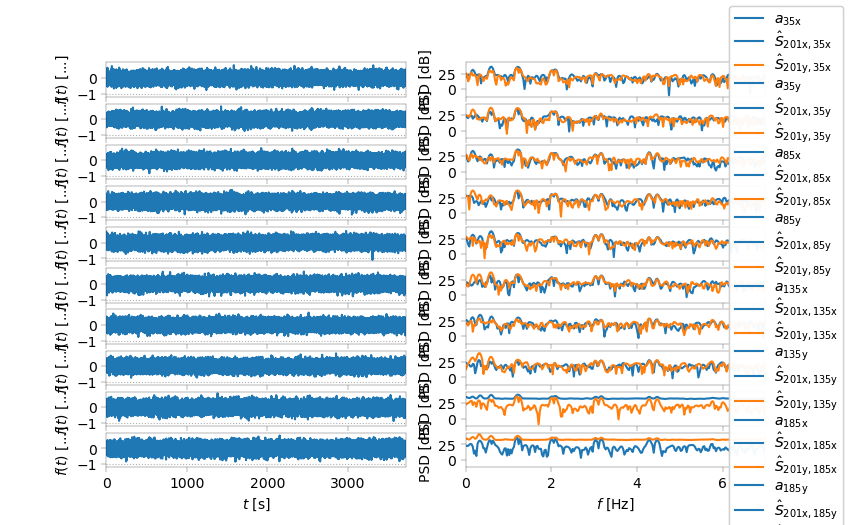

In [260]:
sp = pyOMA.core.PreProcessingTools.SignalPlot(prep_signals)
sp.plot_signals(timescale='time', psd_scale='db',per_channel_axes=True)

### System Identification

In [24]:
order=60
modal_data = BRSSICovRef(prep_signals)
modal_data.build_toeplitz_cov(prep_signals.n_lags // 2)
modal_data.compute_state_matrices(order)

Assembling toeplitz matrix using pre-computed correlation functions 128 block-columns and 129 block rows
Computing state matrices with pinv-based method, with maximum model order 60...


### Reconstruction Error method

The reconstruction error of any system identification method is estimated by a $k$-fold cross validation method \cite{arlot...}. A part of the signal is used for system identification, and the system output is validated against the remaining part. System input and output must not necessarily be timestep signals, but can also be correlation functions, spectral densities, or other derived quantities depending on the employed identification method. In the following the method is given for the covariance-driven Stochastic Subspace Identification method.

The measured signal is divided into $n_{blocks}$ blocks for all channels. The correlation function of the signal from two channels $f$ and $g$ is then computed for each of these blocks using the Blackman-Tukey operator $$\hat{R}_{fg}[m] = \frac{1}{N_{block} - m}\sum_{n=0}^{N_{block} - m - 1} f[n] g[n + m] \; \text{,}$$ where $N_{block}$ is the blocklength in timesteps, and $m$ is the lag step of the correlation function. To avoid large confidence intervals of the correlation function for short blocklengths $N_{block}$ and high lags $m$, the second input signal $g[n+m]$ is allowed to overlap into the consecutive block by $m$ timesteps. The average $\hat{R}_{fg}[m]$ over $(k - 1) \lfloor \frac{n_{blocks}}{k}\rfloor $ randomly selected   blocks is used as input for system identification [^1]. The remainig $\lfloor \frac{n_{blocks}}{k}\rfloor $  are used for system validation. 

Given an identified stochstic state-space model in modally decoupled form $$\mathbf{x}_{j}[k+1] = \mathbf{\Lambda}_d \mathbf{x}_{j}[k] + \mathbf{w}_{j}[k]$$ $$ \mathbf{y}[k] = \mathbf{\Phi}x_{j}[k] + \mathbf{v}_{j}[k] \, \text{,}$$ where $j$ is the mode number,  \cite{reynders2012...} have demonstrated the synthetizaton of correlation functions.
$$ \mathbf{\tilde{R}}^\mathfrak{m}_{fg}[m] = \sum_{j=1}^{n_\mathfrak{m}} \lambda_{j}^{m-1}\mathbf{\phi}_{j}\mathbf{g}_{j}^T$$ and the modal participation vector $\mathbf{g}^\mathfrak{m}_{j}$ is the $j^\mathrm{th}$ column of the modally decomposed next-state output covariance matrix $\mathbf{G}^\mathrm{ref} = \mathbf{\Psi} \mathbf{G}^\mathfrak{m}$.

- Here/Mapping: rebuild corr_matrix_bt from indices
- BRSSICovRef: implement custom corr_matrix_data in single_order_modal (l 326) 
- BRSSICovRef: implement non-modally-decomposed synthetization and single reconstruction error
- Here/Mapping: Average reconstruction error
- test procedures
    
[^1]$\frac{1}{n_{blocks}} \sum_{i=1}^{n_{blocks}} \hat{R}_{fg,i}[m] = \hat{R}_{fg,i}[m]$

#### Example synthetization

In [16]:
# Warning! Computationally expensive, but needed for nice, smooth spectra :-)
prep_signals_temp = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals_temp.add_chan_dofs(chan_dofs)

n_lags = 2048
n_blocks = 1
prep_signals_temp.corr_matrix_bt = None
prep_signals_temp.corr_blackman_tukey(n_lags, num_blocks=n_blocks, refs_only=True)
pass

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=2048 and num_blocks=1...
.............................

[autoreload of pyOMA.core.SSICovRef failed: Traceback (most recent call last):
  File "/home/sima9999/conda/envs/py311/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/sima9999/conda/envs/py311/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/sima9999/conda/envs/py311/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/sima9999/conda/envs/py311/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/sima9999/conda/envs/py311/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/sima9999/conda/envs/py311/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 289, in u

.......................................................................


INFO:pyOMA.core.PreProcessingTools:Estimating Power Spectral Density by Blackman-Tukey's method...
....................................................................................................


(array([<AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>],
       dtype=object),
 array([<AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylabel='PSD [dB]'>,
     

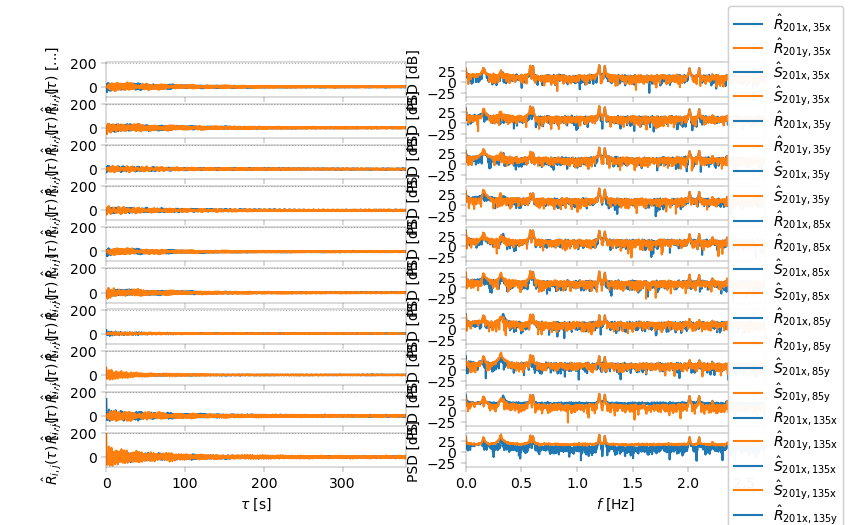

In [171]:
sp = pyOMA.core.PreProcessingTools.SignalPlot(prep_signals_temp)
sp.plot_signals(timescale='lags', psd_scale='db',per_channel_axes=True)

In [61]:
modal_data = BRSSICovRef(prep_signals_temp)
modal_data.build_toeplitz_cov(prep_signals_temp.n_lags // 2)

INFO:pyOMA.core.SSICovRef:Assembling Toeplitz matrix using pre-computed correlation functions 1024 block-columns and 1025 block rows
INFO:pyOMA.core.SSICovRef:Decomposing Toeplitz matrix


In [91]:
order=28
A, C, G = modal_data.compute_state_matrices(order)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.single_order_modal(A, C)
_, this_modal_contributions = modal_data.synthesize_correlation(A, C, G)

In [92]:
np.sum(this_modal_contributions[(this_modal_frequencies<1.5) & (this_modal_frequencies>0.0)]), this_modal_frequencies, acqui_c.modal_frequencies_samp

(0.7890030538247629,
 array([ 1.19998271,  1.24946966,  0.31641286,  0.57988152,  0.6036348 ,
        84.08730041, 84.7955803 , 84.89084853, 85.27063674, 87.30436951,
        88.64152701, 94.18939811,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]),
 array([0.15696927, 0.16334913, 0.17907124, 0.17973269, 0.31541637,
        0.3352036 , 0.5801349 , 0.60380538, 1.19951563, 1.24947417,
        2.01113829, 2.09744073, 3.03492802, 3.16726108, 4.28537709,
        4.47227938]))

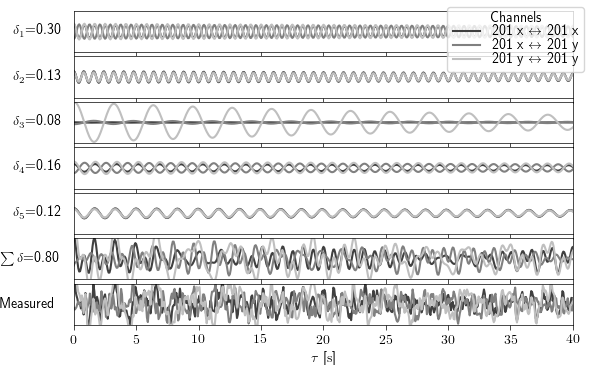

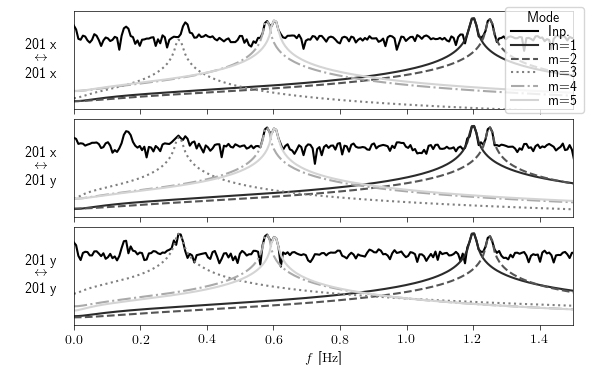

In [78]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    fig1, fig2 = plot_corr_synth(modal_data,
                                 modelist = np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                                 # modelist=[2,3,4,5,7,8,9,10],
                                 # modelist=[10,11,12,13,14,15,16], 
                                 # modelist=[0, 1, 2, 3, 4, 5], 
                                 # modelist=[6, 7, 8, 9,10,11], 
                                 channel_inds=[8,9], ref_channel_inds=[0,1])
    fig1.axes[0].set_ylim((-.003,.003))
    fig1.axes[0].set_xlim((0, 40))
    
    fig2.axes[1].set_xlim((0, 1.5))
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/correlation_synthetization.png')
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/correlation_synthetization.pdf')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization.png')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization.pdf')

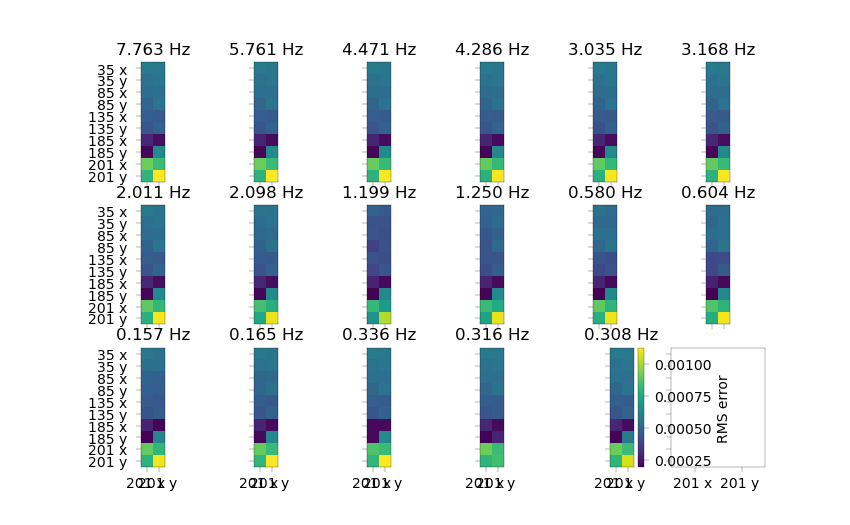

In [19]:
# prep_signals.corr_matrix[-1,-1,:]=0
show_channel_reconstruction(modal_data)

#### Example: Reconstruction Error

The model error with a given parameter set (n_lags, model_order) is sought for by separating the input data into a number of blocks. The sum of modal reconstruction errors is computed on each block model and averaged. This measure can be used to judge on the suitability of the chosen parameter set. However, it is suspectible to overfit. 

How do we penalize overfit?
Overfitted models generally produce almost perfect reconstruction, but achieve that at the cost of many (noise) modes, splitted modes, etc. The number of modes increases, i.e. the "number of directions in the parameter space that are unimportant for prediction" are large. A trade-off between model order and prediction has to be made. This is easily visible in a full-factorial setting or can be found by optimization, but it is not suitable as a UQ criterion, because overfit models would generally perform best.

Wen want the prediction be concentrated to as few modes as possible, i.e. the mean value should be largest? No, because this gives best results at lowest orders.

Additional problem, when modesplitting occurs, one member of the pair may have very high modal contributions, while the other member compensates this with a negative contribution

Its  not known beforehand, how much of the signal can be reconstructed. The question is, how many modes do we need to construct as much of the physical signal (not the noise content) as possible?  An approach would be to segment the sequence of modal contributions of a single model into the modes with high MC and the noise modes. A first approach was to find local minima in estimated kernel densities as the segmentation points. This frequently rejects too many modes (all). A second approach was to find the largest gap in modal contributions (argmax of differences of sorted mcs). That also does not lead to satisfactory results. We seem to have reached a dead-end, where others have failed before and why OMA is generally hard to automate.

We also cannot reject a fixed or a relative number of modes, because we do not know how many physical modes are observable in the signal. Because, ideally, if there is no noise and the right model order is chosen, all modes contribute to the physical signal.


Show a full-factorial example over a range of n_lags and model_orders. Additionally perform a convergence study over the number of blocks.

In [181]:
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals.add_chan_dofs(chan_dofs)

prep_signals.total_time_steps

52080

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=100 and num_blocks=1...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=200 and num_blocks=1...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=300 and num_blocks=1...
....................................................................................................


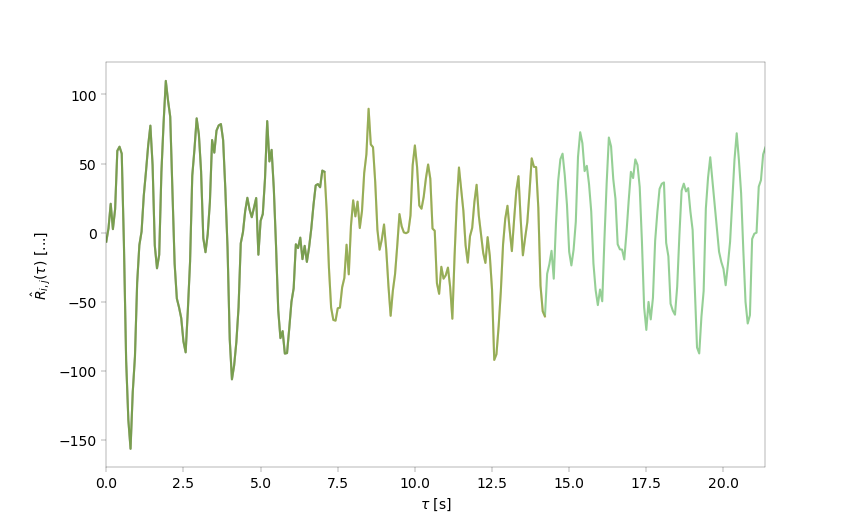

In [289]:
plt.figure()
ax = plt.subplot()
for n_lags in [100,200,300]:
    prep_signals.corr_blackman_tukey(n_lags, refs_only=True)
    pyOMA.core.PreProcessingTools.SignalPlot(prep_signals).plot_correlation(channels=[0], refs=[8], ax=ax, plot_kwarg_dict={'alpha':0.5})
    

In [182]:
n_blocks = 40
k = 10

max_model_order = 40
max_n_lags = 200
n_orders = 37
n_n_lags = 37

orders = np.linspace(max_model_order/10,max_model_order,n_orders, dtype=int)
all_lags = np.linspace(max_n_lags/10,max_n_lags,n_n_lags, dtype=int)

prep_signals.corr_blackman_tukey(max_n_lags, num_blocks=n_blocks, refs_only=True)
all_lags

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=200 and num_blocks=40...
....................................................................................................


array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200])

In [183]:
rng = np.random.default_rng(seed)

cardinality = n_blocks // k
block_indices = np.arange(cardinality*k)
rng.shuffle(block_indices)
block_indices

array([38, 24, 10,  6,  2, 36,  1,  9, 15, 14, 34, 17, 28, 16, 39, 27,  4,
       20,  8, 35, 23, 26, 18, 11, 19,  7, 37, 29,  3, 32, 30, 13, 31, 33,
       25,  0, 21, 22,  5, 12])

In [188]:
if 0:#os.path.exists(result_dir / 'example_reconstruction_validation.npy'):
    all_modal_contributions = np.load(result_dir / 'example_reconstruction_validation.npy')
else:
    logger= logging.getLogger('pyOMA.core.SSICovRef')
    logger.setLevel(level=logging.WARNING)
    modal_data = BRSSICovRef(prep_signals)

    model_performance = np.zeros((n_n_lags, n_orders))
    performance_deviation = np.zeros((n_n_lags, n_orders))
    all_modal_contributions = np.full((n_n_lags, n_orders, k, max_model_order), np.nan)

    for i_n_lags in range(n_n_lags):
        this_n_lags = all_lags[i_n_lags]
        print(this_n_lags//2)
        for i in range(k):

            test_set = block_indices[i * cardinality:(i + 1) * cardinality]
            training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')

            prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[training_set,...,:this_n_lags], axis=0)
            modal_data.build_toeplitz_cov(int(this_n_lags // 2))
            # modal_data.compute_state_matrices(max_model_order)
            prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[test_set,...,:this_n_lags], axis=0)
            
            for i_order in range(n_orders):
                order = orders[i_order]
                
                if order>modal_data.max_model_order: continue
                
                A, C, G = modal_data.compute_state_matrices(order)
                this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.single_order_modal(A, C)
                _, this_modal_contributions = modal_data.synthesize_correlation(A, C, G)
                
                # _, _, _, _, this_modal_contributions = modal_data.single_order_modal(order, synth_corr=True)
                nonzero = this_modal_contributions != 0
                all_modal_contributions[i_n_lags,i_order, i, :np.sum(nonzero)] = this_modal_contributions[nonzero]

    np.save(result_dir / 'example_reconstruction_validation.npy', all_modal_contributions)
    logger.setLevel(level=logging.INFO)


10
12
15
17
20
22
25
27
30
32
35
37
40
42
45
47
50
52
55
57
60
62
65
67
70
72
75
77
80
82
85
87
90
92
95
97
100


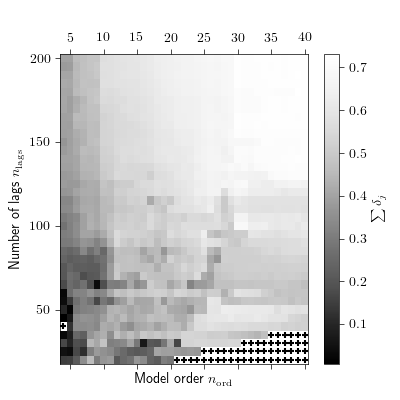

In [221]:
all_modal_contributions2 = np.copy(all_modal_contributions)

#reject noise modes but keep out-of-phase split mode (=negative mc) to counteract high mc of corresponding in-phase mode

if False:
    for i_n_lags in range(n_n_lags):
        for i_order in range(n_orders):

            this_modal_contributions = all_modal_contributions2[i_n_lags, i_order,:,:]
            this_modal_contributions = this_modal_contributions[~np.isnan(this_modal_contributions)]
            this_modal_contributions = np.abs(np.sort(this_modal_contributions))

            if this_modal_contributions.shape[0]<2:continue
            argmax = np.argmax(np.diff(this_modal_contributions))
            thresh = this_modal_contributions[argmax]
            
            this_modal_contributions = all_modal_contributions2[i_n_lags, i_order,:,:]
            indexer = this_modal_contributions**2 <= thresh**2
            all_modal_contributions2[i_n_lags, i_order,  indexer] = np.nan
else:        
    all_negative_contributions = np.copy(all_modal_contributions2)
    all_negative_contributions[all_negative_contributions>=0.0] = np.nan
    all_modal_contributions2[all_modal_contributions2 <=0.0] = np.nan
    pass

#sum over modes, mean over validation sets
model_performance2 = np.nanmean(np.nansum(all_modal_contributions2, axis=3), axis=2)
model_performance3 = np.nanmean(np.nansum(all_negative_contributions, axis=3), axis=2)

model_performance2[model_performance2==0] = np.nan

orderstep = orders[1]-orders[0]
lagstep = all_lags[1]-all_lags[0]

with matplotlib.rc_context(get_pcd('print')):  
    mappable = plt.matshow(model_performance2+model_performance3, 
                           # vmin=0, vmax=1,
                           cmap='Greys_r', 
                extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,all_lags[0]-lagstep/2, all_lags[-1]+lagstep/2], 
                aspect='auto', origin='lower',
                          interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label('$\sum \delta_j$')
    argmax = np.where(np.isnan(model_performance2).T)
    plt.scatter( orders[argmax[0]], all_lags[argmax[1]], marker='+', color='k', s=20)
    # argmax =  np.where(model_performance2.T==model_performance2.max())
    # plt.scatter( orders[argmax[0]], all_lags[argmax[1]], marker='+', color='blue')
    plt.xlabel('Model order $n_\mathrm{ord}$')
    plt.ylabel('Number of lags $n_\mathrm{lags}$')
    
    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error.png')
    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error.pdf')

    

# mappable = plt.matshow(model_performance3, 
#                        # vmin=0.01, vmax=1,
#                        cmap='Greys_r', 
#             extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,all_lags[0]-lagstep/2, all_lags[-1]+lagstep/2], 
#             aspect='auto', origin='lower')
# cbar = plt.colorbar()
# cbar.set_label('Percentage Negative Reconstruction')
# plt.xlabel('Model order')
# plt.ylabel('Number of lags')

# plt.matshow(performance_deviation, cmap='Greys_r', extent=[int(max_model_order/10), max_model_order, int(max_n_lags/10),max_n_lags, ], aspect='auto', origin='lower')
# plt.xlabel('Model order')
# plt.ylabel('Number of lags')
# plt.imshow()

In [222]:
all_modal_contributions2[4,0,:,:]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

n_lags: 186, order: 18


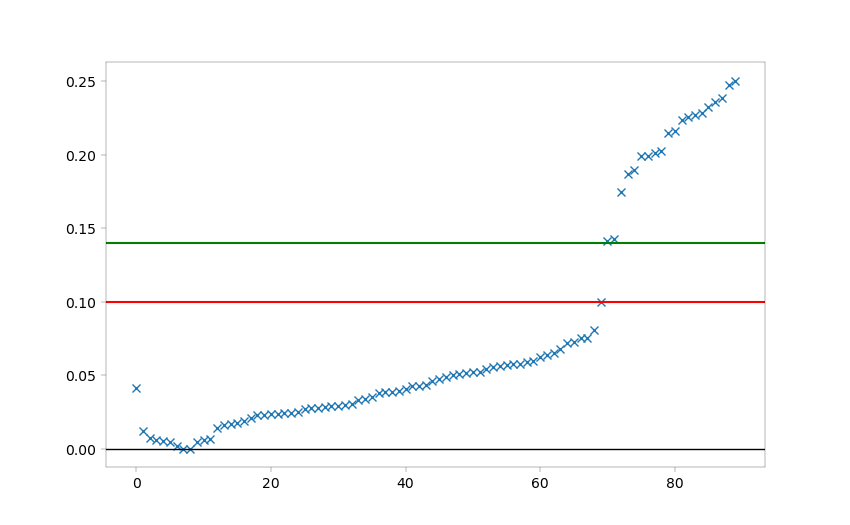

In [560]:
i_lags = np.random.randint(n_n_lags)
i_order = np.random.randint(n_orders//10)

plt.figure()
print(f'n_lags: {all_lags[i_lags]}, order: {orders[i_order]}')
this_modal_contributions = np.copy(all_modal_contributions[i_lags, i_order,:,:])
this_modal_contributions = this_modal_contributions[~np.isnan(this_modal_contributions)]
this_modal_contributions = np.abs(np.sort(this_modal_contributions))

plt.plot(np.abs(this_modal_contributions), marker='x', ls='none')

kernel = scipy.stats.gaussian_kde(this_modal_contributions)
est_points = np.linspace(0, np.max(this_modal_contributions))

kernel_pdf = kernel.pdf(est_points)
bounds = scipy.signal.argrelmax(kernel_pdf)[0]
if bounds.shape[0]<2:
    bounds = [0, this_modal_contributions[-2]]
else:
    bounds = est_points[bounds[[0,-1]]]
opt = scipy.optimize.minimize_scalar(kernel, bounds=bounds)
# opt = scipy.optimize.minimize_scalar(kernel, bounds=(0,np.nanmax(this_modal_contributions)))

plt.axhline(opt.x, color='green')
# plt.axhline(np.nansum(this_modal_contributions) / k)
thresh = this_modal_contributions[np.argmax(np.diff(this_modal_contributions**0.5))]

plt.axhline(thresh, color='red')
plt.axhline(0, color='k', lw=1)

array([0.14265706, 0.25430171])

 message: Solution found.
 success: True
  status: 0
     fun: [ 1.906e+00]
       x: [ 2.464e-01]
     nit: 12
    nfev: 12

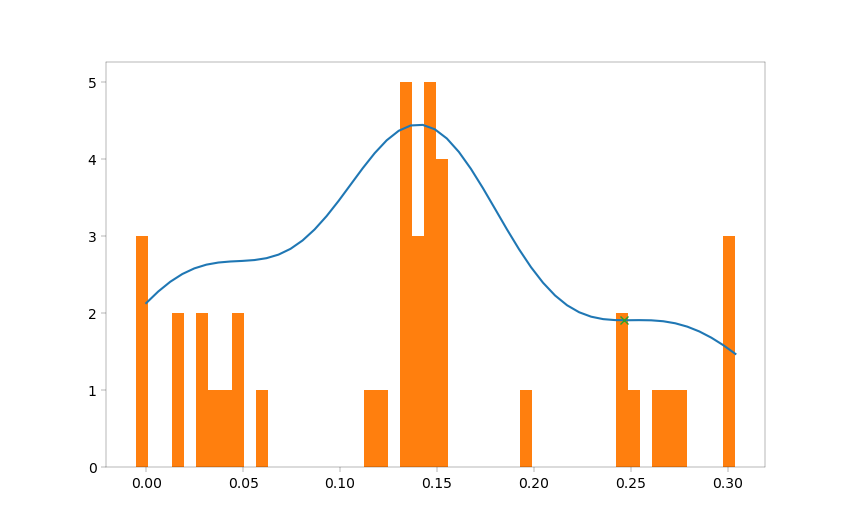

In [275]:
import scipy.stats
import scipy.optimize
import scipy.signal
this_data = np.sort(this_modal_contributions[~np.isnan(this_modal_contributions)])
kernel = scipy.stats.gaussian_kde(this_data, 'scott')
plt.figure()
# plt.hist(this_modal_contributions[~np.isnan(this_modal_contributions)], bins=50)
est_points = np.linspace(0, np.nanmax(this_modal_contributions))
kernel_pdf = kernel.pdf(est_points)
plt.plot(est_points, kernel_pdf)
bounds = scipy.signal.argrelmax(kernel_pdf)[0]
if bounds.shape[0]<2:
    bounds = [0, np.nanmax(this_modal_contributions)]
else:
    bounds = est_points[bounds[[0,-1]]]
display(bounds)
opt = scipy.optimize.minimize_scalar(kernel, bounds=bounds)
display(opt)
display()
plt.hist(this_data, bins=50)
plt.plot(opt.x, opt.fun, marker='x')

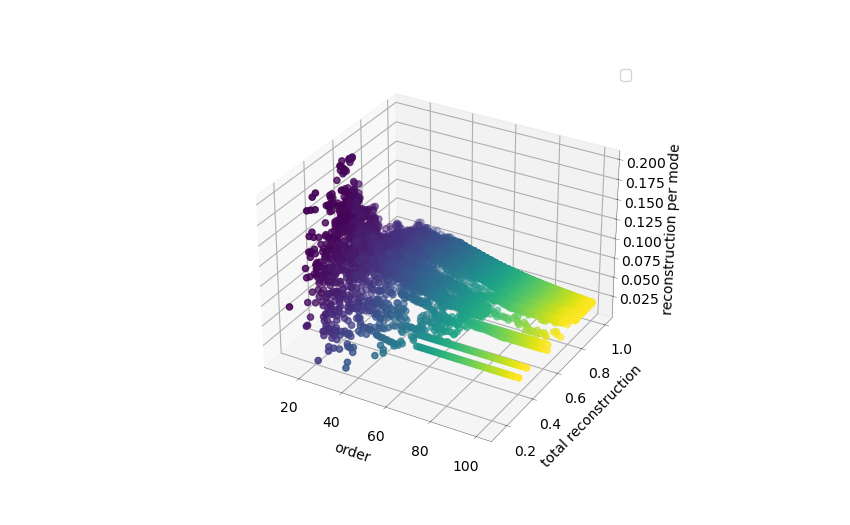

In [172]:
i_lags = 40
# plt.figure()

# plt.plot(np.nanmedian(all_modal_contributions, axis=(2,3))[i_lags,:], label='median')
# plt.plot(np.nansum(all_modal_contributions, axis=(2,3))[i_lags,:]/k, label='average sum')# highest sum from as few modes as possible, that means median should also be high
# plt.scatter(np.nanmedian(all_modal_contributions, axis=(2,3))[i_lags,:], np.nansum(all_modal_contributions, axis=(2,3))[i_lags,:]/k, c=orders)
# plt.xlabel('median')
# plt.ylabel('average sum')
# plt.scatter(np.nanmedian(all_modal_contributions, axis=(2,3))[i_lags,:], np.nanmean(all_modal_contributions, axis=(2,3))[i_lags,:], c=orders)
# plt.xlabel('median')
# plt.ylabel('mean')
# plt.scatter(np.nansum(all_modal_contributions, axis=(2,3))[i_lags,:]/k, np.nanmean(all_modal_contributions, axis=(2,3))[i_lags,:], c=orders)
# plt.xlabel('total reconstruction')
# plt.ylabel('reconstruction per mode')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(np.tile(orders, (1,n_n_lags)), np.nansum(all_modal_contributions, axis=(2,3))[:,:]/k, np.nanmean(all_modal_contributions, axis=(2,3))[:,:], c=np.tile(all_lags,(n_orders,1)))
plt.xlabel('order')
plt.ylabel('total reconstruction')
ax.set_zlabel('reconstruction per mode')
# cbar=ax.colorbar()
# cbar.set_label('Model order')
plt.legend()
# mean should be high, but sum should also be closest to 1

### Modal analysis (manual)

In [6]:
from pyOMA.core.StabilDiagram import StabilCalc, StabilPlot
from pyOMA.GUI.JupyterGUI import StabilGUIWeb

In [16]:
n_blocks = 1
n_lags = 256
order = 50

prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals.add_chan_dofs(chan_dofs)
prep_signals.corr_blackman_tukey(n_lags, num_blocks=n_blocks, refs_only=True)

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=256 and num_blocks=1...
....................................................................................................


array([[[-1.33638029e-04, -5.63173089e-05,  1.53965599e-04, ...,
          5.11712731e-04,  3.18711999e-05, -4.81322203e-04],
        [ 1.31261285e-04,  1.39733086e-04,  5.45795438e-05, ...,
          1.14878358e-03,  1.73939926e-03,  1.45579871e-03]],

       [[ 1.26353086e-04,  1.19927415e-04,  2.36715448e-05, ...,
          1.23042520e-03,  1.85225296e-03,  1.53170200e-03],
        [-2.75909074e-04, -1.83760478e-04,  5.32171957e-05, ...,
          1.45968758e-04, -4.48249707e-04, -1.00198408e-03]],

       [[ 4.31638248e-04,  1.90718363e-04,  3.89966872e-04, ...,
         -1.11565989e-03, -3.21574579e-04,  1.85319595e-04],
        [-2.71922364e-04, -1.63725020e-04,  3.05231399e-05, ...,
         -4.89558881e-05, -1.90943504e-04, -7.11260254e-04]],

       ...,

       [[-2.56886416e-04, -2.46094900e-04, -1.81573504e-04, ...,
          2.96158958e-04,  3.45285587e-04,  4.94469252e-04],
        [ 2.62523241e-03,  3.23729036e-03,  3.18655642e-03, ...,
         -4.74998862e-04, -1.91677

In [11]:
modal_data = BRSSICovRef(prep_signals)
modal_data.build_toeplitz_cov(prep_signalsgnals.n_lags // 2)
modal_data.compute_modal_params(order)

INFO:pyOMA.core.SSICovRef:Assembling Toeplitz matrix using pre-computed correlation functions 128 block-columns and 129 block rows
INFO:pyOMA.core.SSICovRef:Decomposing Toeplitz matrix
INFO:pyOMA.core.SSICovRef:Computing modal parameters...
....................................................................................................


In [41]:
from pyOMA.core.SSIData import SSIDataMC
modal_data = SSIDataMC(prep_signals)
modal_data.build_block_hankel(prep_signals.n_lags)

INFO:pyOMA.core.SSIData:Building subspace matrix...
INFO:pyOMA.core.SSIData:Decomposing Block-Hankel Matrix


In [21]:
A,C,Q,R,S = modal_data.estimate_state(20)
j=500
sig_synth, modal_contributions = modal_data.synthesize_signals( A, C, Q, R, S, j=j)
sig = prep_signals.signals

In [36]:
modal_data.S.shape

(10,)

In [42]:
modal_data.compute_modal_params(order, j=500)

INFO:pyOMA.core.SSIData:Computing modal parameters...
....................................................................................................


In [43]:
stabil_calc = StabilCalc(modal_data)
stabil_plot = StabilPlot(stabil_calc)
stabil_plot.show_MC(True)
display(StabilGUIWeb(stabil_plot))

Checking stabilisation criteria...
....................................................................................................


In [113]:
inds = np.array(stabil_calc.select_modes).T

this_modal_frequencies = modal_data.modal_frequencies[inds[0,:],inds[1,:]]
this_modal_damping = modal_data.modal_damping[inds[0,:],inds[1,:]]
this_mode_shapes = modal_data.mode_shapes[:, inds[1,:],inds[0,:]]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### Mode shape visualization (numerical, identified, manually identified)

In [53]:
inds_num, inds_ident, unp_num, unp_ident = pair_modes(
    acqui_c.modal_frequencies_samp, this_modal_frequencies, 
    acqui_c.mode_shapes_samp, this_mode_shapes, 
    freq_thresh=0.2, mac_thresh=0.6)

all_inds_ident = np.concatenate((inds_ident, unp_ident))
corr_inds_num = np.ma.concatenate((inds_num, np.ma.array(np.zeros_like(unp_ident), mask=np.ones_like(unp_ident, dtype=bool))))

# indices of numerical modes in the order of identified modes (for each id mode the index of num mode of nan)
corr_inds_num_sort = corr_inds_num[np.argsort(all_inds_ident)] 

'''
assume numerical frequencies to be sorted ascendingly

indices should be usable to:
    - reduce both sets of modal parameters to their matching sets (inds_num, inds_ident)
    - leading set are the identified modal parameters, they are stored in the database unordered, none should be discarded
    - assign identified modal parameters to numerical ones (corr_inds_num_sort
        - for each identified modal parameter
        - set the index of the corresponding numerical modal parameter
        - if there is no corresponding, mask the value
'''
corr_inds_num_sort

masked_array(data=[29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
                   15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 4, --],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False,  True],
       fill_value=999999)

In [54]:
num_freqs_corr = np.ma.array(acqui_c.modal_frequencies_samp[corr_inds_num_sort], 
                             mask=corr_inds_num_sort.mask, 
                             fill_value=np.nan
                            ).filled()
num_damps_corr = np.ma.array(acqui_c.modal_damping_samp[corr_inds_num_sort] * 100, 
                             mask=corr_inds_num_sort.mask, 
                             fill_value=np.nan
                            ).filled()
num_msh_corr = np.ma.array(acqui_c.mode_shapes_samp[:,corr_inds_num_sort], 
                           mask=np.repeat(corr_inds_num_sort.mask[np.newaxis, :], acqui_c.mode_shapes_samp.shape[0], axis=0), 
                           fill_value=np.nan
                          ).filled()


freq_diffs = num_freqs_corr - this_modal_frequencies
damp_diffs = num_damps_corr - this_modal_damping
mac_matrix = StabilCalc.calculateMAC(num_msh_corr, this_mode_shapes)


macs = np.diag(mac_matrix)
display(f'Statistics on identification: Δf = {np.nanmean(freq_diffs):1.3f}± {np.nanstd(freq_diffs):1.3f}, Δd = {np.nanmean(damp_diffs):1.3f}± {np.nanstd(damp_diffs):1.3f}, MAC: mean = {np.nanmean(macs):1.3f}, min= {np.nanmin(macs):1.3f}, Number of unmatched identified modes {len(unp_ident)}')


'Statistics on identification: Δf = 0.000± 0.010, Δd = -0.450± 1.734, MAC: mean = 0.987, min= 0.851, Number of unmatched identified modes 1'

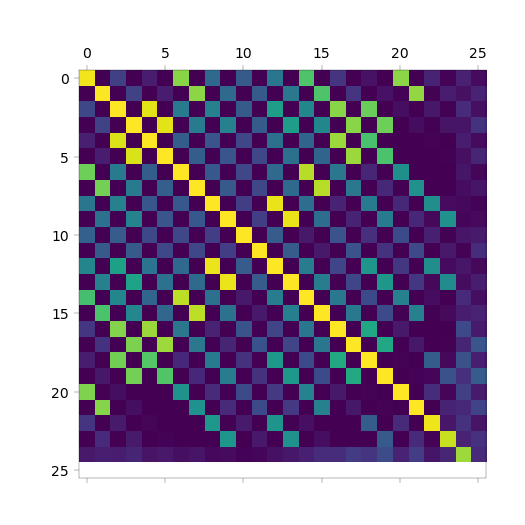

In [55]:
plt.matshow(mac_matrix)

##### Manual

In [38]:
mode_shape_plot = ModeShapePlot(amplitude=10,
                                prep_signals=prep_signals,
                                stabil_calc=stabil_calc,
                                geometry_data=geometry,
                                modal_data=stabil_calc.modal_data)

##### Numerical

In [509]:
merged_data = MergePoSER()

merged_data.mean_damping = acqui_c.modal_damping_samp[inds_num,np.newaxis]
merged_data.mean_frequencies = acqui_c.modal_frequencies_samp[inds_num,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = acqui_c.mode_shapes_samp[:,np.newaxis,inds_num]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [510]:
mode_shape_plot_num = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )
mode_shape_plot = mode_shape_plot_num

##### Identified

In [511]:
merged_data = MergePoSER()

merged_data.mean_damping = this_modal_damping[inds_ident,np.newaxis]
merged_data.mean_frequencies = this_modal_frequencies[inds_ident,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = this_mode_shapes[:,np.newaxis,inds_ident]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [512]:
mode_shape_plot_id = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )
mode_shape_plot = mode_shape_plot_id

### Display

In [39]:
display(PlotMSHWeb(mode_shape_plot))

29 0.15825595589660485 nan 1.6859383432497572 nan 0.8774699994004874 170.32860318422212 8.820093241375405 0.0031210831649046153 0.003128780555222894 nan 0.0011550589798115104 nan nan


In [521]:
mode_shape_plot_num.reset_view()
mode_shape_plot_id.reset_view()

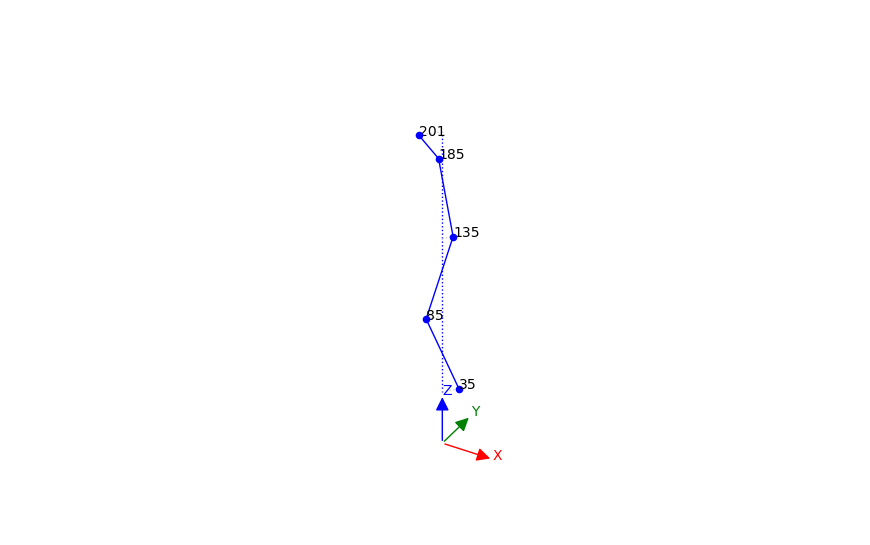

1.1995156332018202

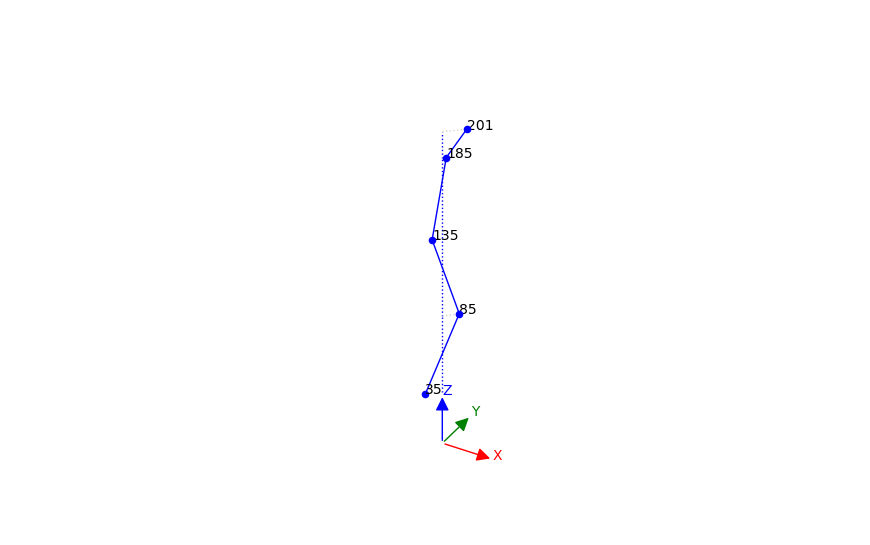

1.1980469802369533

In [534]:
ind=3
_,_,frequency_num,_,_,_,_ = mode_shape_plot_num.change_mode(index=ind)
_,_,frequency_id,_,_,_,_ = mode_shape_plot_id.change_mode(index=ind)
display(mode_shape_plot_num.fig, frequency_num, mode_shape_plot_id.fig,frequency_id)

## Continue


Write modal contribution for SSI Data and add a small example
Implement Multi- Block modal contribution PhD Doehler p. 75

continue with the mapping and its verification
    - add total modal_contributions as output
    - implement modepairing for ordered output, or are we pairing post-sampling?
    


Further test mapping parameters noise etc for any unwanted/unrealistic effects on the identification
 - verification manually or automatic
   - automatic (see UQ_Acqui.ipynb): 
     - proper modepairing with numerical where excess-modes may be present in both numerical and identified
     - statistics on MAC, frequency deviations, damping deviations, number of unmatched identified modes
     - MAC might have a problem with rotated modeshapes
     - available for inclusion in mapping and final verification
     - also modeshape order and major/minor direction can be marked for each identified mode to validate any output-only method for mode clustering

    
check modeshape rotation with a different example (where alpha is odd)     
then just choose a different example and see, if everything works as expected

- get bounds of every parameter
- run full factorial over bounds
- 


